# Deep Learning HW1-2  

## Convolutional Neural Network for Recognition

In [86]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as Data

In [87]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [88]:
#先讀取圖片檔
img_path = r'C:\Users\kevin\DeepLearning\DL_HW1\Problem2\images'
train_img = []
test_img = []
for index in train['file_name']:
    train_img.append(Image.open(img_path + '\\' + str(index)))
for index in test['file_name']:
    test_img.append(Image.open(img_path + '\\' + str(index)))
    

In [89]:
#圖片前處理

#有crop的前處理
def img_process_crop(data,info,size):
    crop_img = []
    label = []
    
    for i in range(len(data)):
        x1 = info.iloc[i]['x1']
        x2 = info.iloc[i]['x2']
        y1 = info.iloc[i]['y1']
        y2 = info.iloc[i]['y2']
        label.append(info.iloc[i]['category'])

           #將圖片crop並resize，除以255，存在crop_img中
        processed_img = np.array(data[i].crop((x1,y1,x2,y2)).resize((size,size)))/255
        crop_img.append(processed_img)
    
    return crop_img,label

#沒有Crop的前處理
def img_process(data,info,size):
    crop_img = []
    label = []
    
    for i in range(len(data)):
        label.append(info.iloc[i]['category'])

           #將圖片resize，除以255，存在crop_img中
        processed_img = np.array(data[i].resize((size,size)))/255
        crop_img.append(processed_img)
    
    return crop_img,label
        

In [90]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(3,8,kernel_size=5,stride =1, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(8,16,kernel_size=5,stride =1, padding=2)
        self.cnn3 = nn.Conv2d(16,24,kernel_size=5,stride =1, padding=2)
        
        self.fc1 = nn.Linear(384 , 64)
        self.fc2 = nn.Linear(64, 2)
        self.fc3 = nn.Linear(2, 7)
        
        
    def forward(self, x):
        
        out = self.pool(self.relu(self.cnn1(x)))
        out = self.pool(self.relu(self.cnn2(out)))
        out = self.pool(self.relu(self.cnn3(out)))
        #Reshape
        out = out.view(-1,384)
        out = F.relu(self.fc1(out))
        self.fc2_out = self.fc2(out)
        out = self.fc3(self.fc2_out)
         
        return out

In [91]:
def run_test():
    with torch.no_grad():
        correct =0
        total =0

        for test_image, test_label in test_loader:
            test_image = test_image.permute(0,3,1,2)
            test_image = torch.tensor(test_image, dtype=torch.float32)

            test_output = cnn(test_image)
            
            _,test_predict = torch.max(test_output.data,1)
            total += test_label.size(0)
            correct += (test_predict == test_label).sum().item()
            
            test_loss = criterion(test_output, test_label)

    return correct/total, np.float64(test_loss)

In [92]:
def get_latent():
    distribute = cnn.fc2_out

    distribute = distribute.numpy()


    class_distribute = [[],[],[],[],[],[],[]]

    for i in range(len(distribute)):

        class_distribute[y_test[i]].append([distribute[i][0],distribute[i][1],y_test[i]])
    
    return class_distribute
    
def plot(class_distribute, epoch):

    fig=plt.figure(figsize=(6,4))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(np.array(class_distribute[0]).T[0], np.array(class_distribute[0]).T[1], color='red',label='0')
    ax.scatter(np.array(class_distribute[1]).T[0], np.array(class_distribute[1]).T[1], color='green',label='1')
    ax.scatter(np.array(class_distribute[2]).T[0], np.array(class_distribute[2]).T[1], color='blue',label='2')
    ax.scatter(np.array(class_distribute[3]).T[0], np.array(class_distribute[3]).T[1], color='gray',label='3')
    ax.scatter(np.array(class_distribute[4]).T[0], np.array(class_distribute[4]).T[1], color='orange',label='4')
    ax.scatter(np.array(class_distribute[5]).T[0], np.array(class_distribute[5]).T[1], color='brown',label='5')
    ax.scatter(np.array(class_distribute[6]).T[0], np.array(class_distribute[6]).T[1], color='pink',label='6')
    ax.set_title('epoch:'+str(epoch))
    ax.legend()
    plt.show()

    

## 1(a) 

### Learning curve and the accuracy rate (No Crop)

In [114]:
processed_img_train, y_train = img_process(train_img,train,32)
processed_img_test, y_test = img_process(test_img,test,32)

#將圖片資料和label轉成torch的tensor形式
train_features = torch.from_numpy(np.array(processed_img_train))
train_label = torch.from_numpy(np.array(y_train))
test_features = torch.from_numpy(np.array(processed_img_test))
test_label = torch.from_numpy(np.array(y_test))

#將input數據和目標label打包
train_set = Data.TensorDataset(train_features.double(),train_label)
test_set = Data.TensorDataset(test_features.double(),test_label)


#Hyper parameters
batch_size =128

train_loader = Data.DataLoader(train_set,batch_size = batch_size,shuffle='False')
test_loader = Data.DataLoader(test_set,batch_size = len(test_set),shuffle='False')

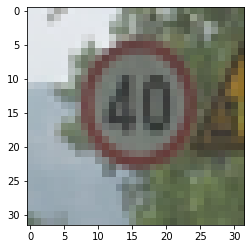

In [115]:
plt.imshow(processed_img_train[0])

圖示：沒有經過Cropping的圖片

In [116]:
cnn = CNN_Model()

In [117]:
#NO CROP


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

acc_list = [[],[]]  #train and test
loss_list =[[],[]]  #train and test
latent=[]

for epoch in range(200):
    
    for i,data in enumerate(train_loader,0):
        inputs, labels = data
        inputs = inputs.permute(0,3,1,2)
        optimizer.zero_grad()
        
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
       
        
        loss.backward()
        optimizer.step()
        

    _,train_predict = torch.max(outputs.data,1)

    acc = (train_predict == labels).sum().item()/labels.size(0)

    test_acc, test_loss = run_test()

    acc_list[0].append(acc)
    acc_list[1].append(test_acc)

    loss_list[0].append(np.float64(loss))
    loss_list[1].append(test_loss)
    
    if epoch%10==9:
        print('epoch:',epoch+1,end='')
        print(' iterations:',i+1,end='')
        print(' trianing loss:',loss)
    
    if epoch==2:
        latent.append(get_latent())
    if epoch==120:
        latent.append(get_latent())
    


<ipython-input-117-2f38ebab341f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-91-73b15d228f2b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_image = torch.tensor(test_image, dtype=torch.float32)


epoch: 10 iterations: 11 trianing loss: tensor(1.1806, grad_fn=<NllLossBackward>)
epoch: 20 iterations: 11 trianing loss: tensor(0.4370, grad_fn=<NllLossBackward>)
epoch: 30 iterations: 11 trianing loss: tensor(0.2441, grad_fn=<NllLossBackward>)
epoch: 40 iterations: 11 trianing loss: tensor(0.2585, grad_fn=<NllLossBackward>)
epoch: 50 iterations: 11 trianing loss: tensor(0.0907, grad_fn=<NllLossBackward>)
epoch: 60 iterations: 11 trianing loss: tensor(0.0724, grad_fn=<NllLossBackward>)
epoch: 70 iterations: 11 trianing loss: tensor(0.0569, grad_fn=<NllLossBackward>)
epoch: 80 iterations: 11 trianing loss: tensor(0.0165, grad_fn=<NllLossBackward>)
epoch: 90 iterations: 11 trianing loss: tensor(0.0074, grad_fn=<NllLossBackward>)
epoch: 100 iterations: 11 trianing loss: tensor(0.0029, grad_fn=<NllLossBackward>)
epoch: 110 iterations: 11 trianing loss: tensor(0.0027, grad_fn=<NllLossBackward>)
epoch: 120 iterations: 11 trianing loss: tensor(0.0023, grad_fn=<NllLossBackward>)
epoch: 130 it

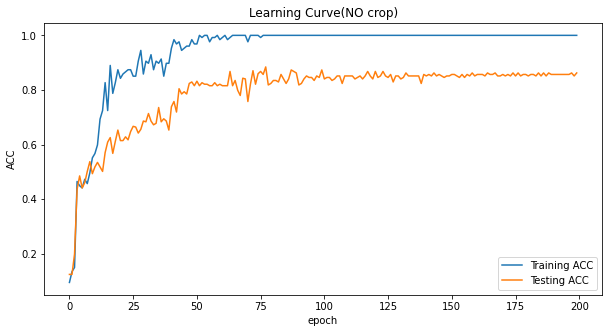

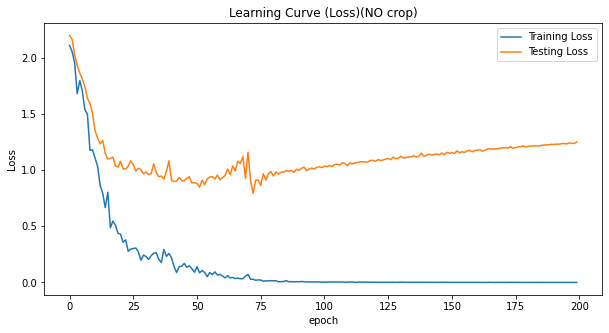

In [118]:
plt.figure(figsize=(10,5))
plt.plot(acc_list[0],label='Training ACC')
plt.plot(acc_list[1],label='Testing ACC')
plt.title('Learning Curve(NO crop)')
plt.xlabel('epoch')
plt.ylabel('ACC')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(loss_list[0],label='Training Loss')
plt.plot(loss_list[1],label='Testing Loss')
plt.title('Learning Curve (Loss)(NO crop)')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


第一題：

圖片在沒有crop的處理下，大約在第75個epoch訓練資料逐漸收斂，但testing資料ACC只達到最高約80%。

Training set 的Loss值在第25epoch之後便到達低點大約0.8~1.0，之後卻不減反增，我覺得應該是遇到了Overfitting的問題。 


## 1(b)

### Plot the latent feature distributions of test data

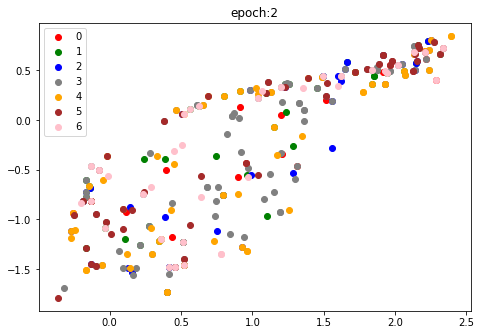

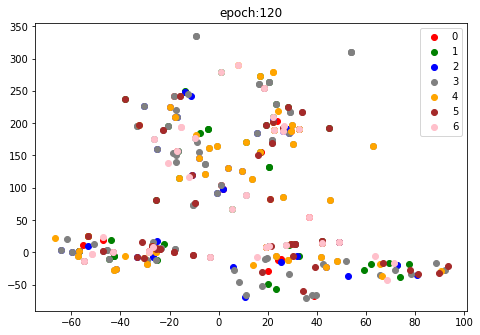

In [119]:

plot(latent[0],2)
plot(latent[1],120)


Latent features distribution來看，圖片沒有經過crop的處理，好像沒有明顯的區別資料。

## 2.(a)

###  With Cropping，Plot the learning curve, accuracy rate and the latent feature distributions of test data. 

In [105]:
processed_img_train, y_train = img_process_crop(train_img,train,32)
processed_img_test, y_test = img_process_crop(test_img,test,32)

#將圖片資料和label轉成torch的tensor形式
train_features = torch.from_numpy(np.array(processed_img_train))
train_label = torch.from_numpy(np.array(y_train))
test_features = torch.from_numpy(np.array(processed_img_test))
test_label = torch.from_numpy(np.array(y_test))

#將input數據和目標label打包
train_set = Data.TensorDataset(train_features.double(),train_label)
test_set = Data.TensorDataset(test_features.double(),test_label)


#Hyper parameters
batch_size =128

train_loader = Data.DataLoader(train_set,batch_size = batch_size,shuffle='False')
test_loader = Data.DataLoader(test_set,batch_size = len(test_set),shuffle='False')

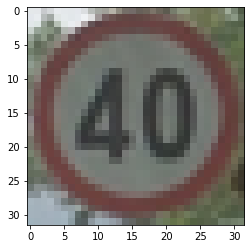

In [106]:
plt.imshow(processed_img_train[0])

圖示：圖片經過cropping之後，去除背景，僅留下需要辨識的交通號誌部分。

In [110]:
cnn = CNN_Model()

In [111]:
#with Cropping

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

acc_list = [[],[]]  #train and test
loss_list =[[],[]]  #train and test
latent=[]

for epoch in range(200):
    
    for i,data in enumerate(train_loader,0):
        inputs, labels = data
        inputs = inputs.permute(0,3,1,2)
        optimizer.zero_grad()
        
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
       
        
        loss.backward()
        optimizer.step()
        

    _,train_predict = torch.max(outputs.data,1)

    acc = (train_predict == labels).sum().item()/labels.size(0)

    test_acc, test_loss = run_test()

    acc_list[0].append(acc)
    acc_list[1].append(test_acc)

    loss_list[0].append(np.float64(loss))
    loss_list[1].append(test_loss)
    
    if epoch%10==9:
        print('epoch:',epoch+1,end='')
        print(' iterations:',i+1,end='')
        print(' trianing loss:',loss)
    
    if epoch==2:
        latent.append(get_latent())
    if epoch==120:
        latent.append(get_latent())
    


<ipython-input-111-7dfe1bed5feb>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-91-73b15d228f2b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_image = torch.tensor(test_image, dtype=torch.float32)


epoch: 10 iterations: 11 trianing loss: tensor(1.0215, grad_fn=<NllLossBackward>)
epoch: 20 iterations: 11 trianing loss: tensor(0.4489, grad_fn=<NllLossBackward>)
epoch: 30 iterations: 11 trianing loss: tensor(0.2974, grad_fn=<NllLossBackward>)
epoch: 40 iterations: 11 trianing loss: tensor(0.2548, grad_fn=<NllLossBackward>)
epoch: 50 iterations: 11 trianing loss: tensor(0.0307, grad_fn=<NllLossBackward>)
epoch: 60 iterations: 11 trianing loss: tensor(0.0051, grad_fn=<NllLossBackward>)
epoch: 70 iterations: 11 trianing loss: tensor(0.0040, grad_fn=<NllLossBackward>)
epoch: 80 iterations: 11 trianing loss: tensor(0.0024, grad_fn=<NllLossBackward>)
epoch: 90 iterations: 11 trianing loss: tensor(0.0021, grad_fn=<NllLossBackward>)
epoch: 100 iterations: 11 trianing loss: tensor(0.0042, grad_fn=<NllLossBackward>)
epoch: 110 iterations: 11 trianing loss: tensor(0.0006, grad_fn=<NllLossBackward>)
epoch: 120 iterations: 11 trianing loss: tensor(0.0006, grad_fn=<NllLossBackward>)
epoch: 130 it

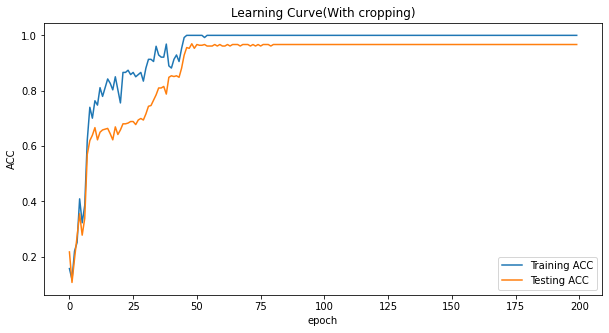

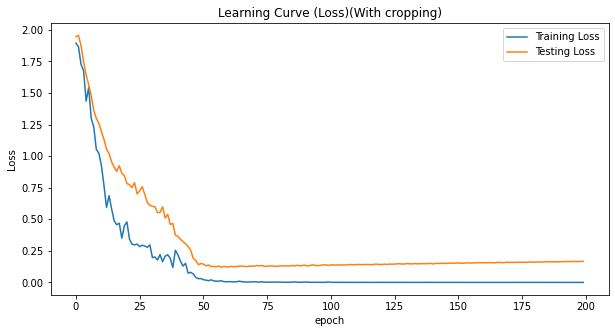

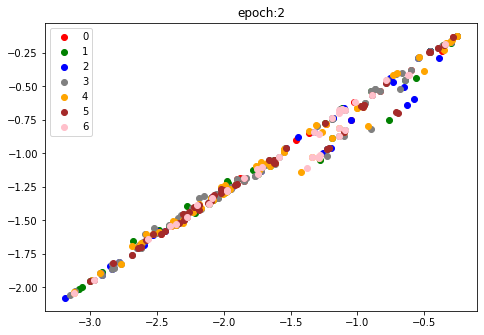

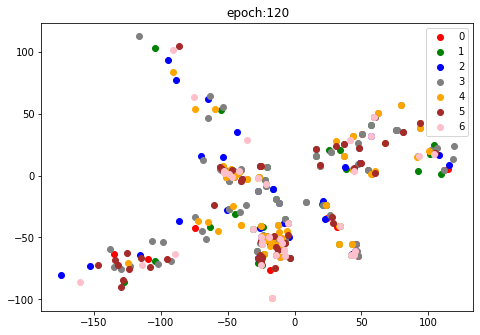

In [112]:
plt.figure(figsize=(10,5))
plt.plot(acc_list[0],label='Training ACC')
plt.plot(acc_list[1],label='Testing ACC')
plt.title('Learning Curve(With cropping)')
plt.xlabel('epoch')
plt.ylabel('ACC')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(loss_list[0],label='Training Loss')
plt.plot(loss_list[1],label='Testing Loss')
plt.title('Learning Curve (Loss)(With cropping)')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plot(latent[0],2)
plot(latent[1],120)

第二題：

圖片經過crop之後，訓練資料更快在第50個epoch之後達到收斂，testing的ACC也表現不錯有達到約90~95%。

Loss的部分可以看到testing資料也穩定的下降，雖然之後有稍微一點的爬升，但相對於沒有crop的圖片收斂結果更佳、更穩定。

對於Latent features distribution可以看到圖片經過crop之後可以有更明顯的區別資料特徵。

## 2(b)

### Discussions on result of 1 and 2

經過第一題和第二題的訓練比較之後，可以得出幾個結論：

１．在模型訓練的收斂速度上，有經過Cropping的圖片，會比沒有經過Cropping的圖片更快。

２．模型訓練到後面的穩定度來說，經過Cropping的圖片會比沒有Cropping的圖片更穩定。

３．模型對於未知資料的泛化程度，也可以看出經過Cropping的圖片會較高（相對於第一題Testing set的Acc只有大約80%，在第二題中可以到達90~95%左右）

學生做完第一題和第二題的比較，覺得跑出來的結果滿符合常理的，因為有經過Crop之後的圖片，去除一些不相關的資訊(背景圖像)，讓機器學習模型可以更專注在辨識交通號誌本體的圖片上，而不會受到其他不相關的像素影響。